# Principal Component Analysis & Linear Regression

Bu calismada finans verisi uzerinde PCA feature selection algoritmasi ve Linear Regression uygulanarak hedef degiskeni tahmini gerceklestirildi.

In [144]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler,scale, Normalizer
from scipy import stats
from sklearn.decomposition import PCA

from warnings import filterwarnings
filterwarnings('ignore')

In [145]:
def correlation_df(data, remove_columns=None):
    if(remove_columns is None):
        corr = data.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    else:
        data2 = data.drop(remove_columns, axis=1)
        corr = data2.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    return new_df

def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

## Layer(1) --> feature-feature Correlation

def layer1(data_norm, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data_norm.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df

def layer2(fs_df,num_feats, target):
    x = fs_df.iloc[:,:-1]
    y = fs_df[target]
    cor_list = []
    feature_name = list(x.columns)
    #Calculate the co-relation with y for each feature
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)
#replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
# feature name
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
#feature selection? 0 for not select, 1 for select
#cor_support = [True if i in cor_feature else False for i in feature_name]
#return cor_support, cor_feature
    return cor_feature

## Data Importing

In [146]:
data = pd.read_excel("HW_Data_Set.xlsx")
data.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,-152,-353,1.0,0.498547,0.701906,15.135802,35.625252,36.997753
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,-158,-359,1.0,0.537088,0.690833,15.143348,35.643013,37.016198
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,-160,-362,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,-166,-367,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,-186,-388,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503


# 1. Data Exploration

### 1.1. Data Statistics

In [147]:
desc_df = data.describe().T
null_count = data.isnull().sum()
null_percent = (data.isnull().sum() / data.count())*100
variance = data.var()

desc_df["variance"] =  round(variance,3)
desc_df["null_values"] = round(null_count,3)
desc_df["null__rate"] = round(null_percent,3)
desc_df.T

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target
count,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,...,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000
mean,-0.803146,-0.803470,48.388890,48.289282,0.099609,49.488867,-18.497518,11.771485,11.773550,11.773392,...,0.000224,28.529204,-8.554792,-28.166694,0.490297,0.498188,0.490174,-0.057102,-2.906358,-3.315072
std,23.624403,23.624144,36.388526,36.478009,60.414625,12.198722,68.281120,6.803997,5.786089,4.970499,...,0.005660,26.316896,16.100087,23.271524,0.425376,0.228547,0.150483,14.834497,34.559778,36.841541
min,-131.000000,-131.000000,0.000000,0.000000,-100.000000,12.134540,-625.093855,1.050000,1.660000,2.580000,...,-0.023790,0.000000,-103.800000,-188.000000,0.000000,0.000000,0.083530,-15.780588,-37.142889,-38.573858
25%,-14.000000,-14.000000,14.285714,14.285714,-50.000000,40.868503,-45.687212,6.850000,7.260000,7.635000,...,-0.003230,10.700000,-11.700000,-39.000000,0.000000,0.323783,0.379894,-15.350354,-36.208094,-37.695273
50%,0.000000,0.000000,50.000000,50.000000,0.000000,49.549766,-2.817298,10.550000,11.040000,11.270000,...,-0.000053,21.300000,0.000000,-22.000000,0.473684,0.495192,0.487078,0.000000,-34.267756,-35.788391
75%,13.000000,13.000000,85.714286,85.714286,57.142857,58.504375,28.072613,14.950000,15.040000,14.960000,...,0.003414,38.400000,0.000000,-11.000000,1.000000,0.675730,0.601508,15.385945,35.879524,37.521892
max,76.000000,76.000000,100.000000,100.000000,100.000000,84.821848,81.105847,82.900000,54.240000,37.050000,...,0.023340,281.800000,0.000000,0.000000,1.000000,1.000000,0.868534,15.768767,37.038694,38.465649
variance,558.112000,558.100000,1324.125000,1330.645000,3649.927000,148.809000,4662.311000,46.294000,33.479000,24.706000,...,0.000000,692.579000,259.213000,541.564000,0.181000,0.052000,0.023000,220.062000,1194.378000,1357.299000
null_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 1.2. Numeric ve Categoric Features

In [148]:
num, cat = numeric_categoric_variable(data)

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

### 1.3. Different Values

Kategorik verilerde kaç farklı kategori mevcut olduğunu kontrol ediyoruz. ind_420 ve ind_422 özniteliklerde sırasıyla 582 ve 573 olmak üzere farklı kategori mevcut olduğu çıkıyor. Bu nedenle group by ile değerleri kontrol ettiğimizde tüm değerlerin numerik olduğunu ve "?" olarak girilen 1041 satır kirli veri olduğunu görüyoruz. Veri Temizleme işlemi uygulamamız gerekiyor.

In [149]:
for i in data.select_dtypes(include=["object"]).columns:
    print(i,": ",data[i].value_counts().count())

ind_109 :  2
ind_420 :  582
ind_422 :  573


### 1.4. 50_target Distribution

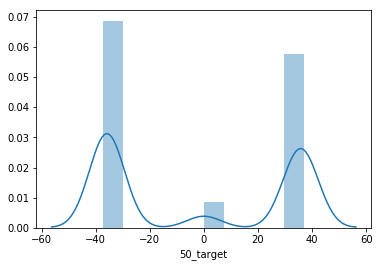

Skewness: 0.160870 
Kurtosis: -1.904826 


In [150]:
sns.distplot(data["50_target"])
plt.show()

print("Skewness: %f " % data["50_target"].skew())
print("Kurtosis: %f " % data["50_target"].kurt())

# 2 Data Preprocessing

### 2.1. Veri Temizleme (Drop columns)

Burada "?" değerleri içeren ind_420 ve ind_422 özniteliklerini verisetimizden siliyoruz.

In [151]:
## data temizleme

#data["ind_420"] = data["ind_420"].replace("?", np.nan)
#data["ind_422"] = data["ind_422"].replace("?", np.nan)

data = data.drop(["ind_420", "ind_422"], axis=1)

### 2.2. Dummy Dönüştürme

ind_109 değişkeni kategorik değişkenlerdir. GREEN ve RED değerleri aldığı için hedef değişkeni tahmin etmede önemli olacağını düşünerek dönüştürme işlemi uyguladım.

In [152]:
## dummy degisken 

dummy = pd.get_dummies(data["ind_109"])
data_dummy = pd.concat([data, dummy],axis=1)
data_dummy = data_dummy.drop(["ind_109"], axis=1)
data_dummy.head(3)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target,GREEN,RED
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,1.0,0.498547,0.701906,15.135802,35.625252,36.997753,1,0
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,1.0,0.537088,0.690833,15.143348,35.643013,37.016198,1,0
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805,1,0


### 2.3. Normalization


#### 2.3.1. Min-Max 

In [153]:
## minmax 
scaler = MinMaxScaler()
scaler.fit(data_dummy)
data_minmax = scaler.transform(data_dummy)
data_minmax = pd.DataFrame(data_minmax, columns=data_dummy.columns)
data_minmax.head(3)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target,GREEN,RED
0,0.724638,0.714976,1.0,0.857143,0.571429,0.828604,0.971259,0.277947,0.303537,0.265448,...,0.522158,0.712766,1.0,0.498547,0.787736,0.979937,0.980946,0.980946,1.0,0.0
1,0.748792,0.724638,1.0,0.785714,0.607143,0.854913,0.976297,0.127062,0.313808,0.279663,...,0.464355,0.680851,1.0,0.537088,0.773630,0.980177,0.981186,0.981186,1.0,0.0
2,0.777778,0.748792,1.0,0.714286,0.642857,0.866807,0.978490,0.094075,0.308102,0.281404,...,0.437380,0.680851,1.0,0.615169,0.776441,0.980288,0.981297,0.020107,1.0,0.0


#### 2.3.2. Standard Scaler

In [154]:
## standard scaler 
scaler2 = StandardScaler()
scaler2.fit(data_dummy)
data_stdscaler = scaler2.transform(data_dummy)
data_stdscaler = pd.DataFrame(data_stdscaler, columns=data_dummy.columns)
data_stdscaler.head(3)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target,GREEN,RED
0,0.838318,0.753674,1.41845,1.026044,0.234831,1.875320,1.161562,1.768003,1.010514,-0.008731,...,-2.549585,-1.110172,1.198341,0.001568,1.407132,1.024243,1.115017,1.094311,0.984393,-0.984393
1,1.049980,0.838340,1.41845,0.830215,0.353072,2.032100,1.213674,-0.047253,1.103849,0.089859,...,-2.922284,-1.368019,1.198341,0.170218,1.333540,1.024752,1.115531,1.094811,0.984393,-0.984393
2,1.303976,1.050005,1.41845,0.634387,0.471312,2.102976,1.236362,-0.444111,1.051996,0.101931,...,-3.096210,-1.368019,1.198341,0.511884,1.348207,1.024990,1.115771,-0.915067,0.984393,-0.984393


#### 2.3.3. Normalizer

In [155]:
## Normalizer 
scaler3 = Normalizer()
scaler3.fit(data_dummy)
data_normalizer = scaler3.transform(data_dummy)
data_normalizer = pd.DataFrame(data_normalizer, columns=data_dummy.columns)
data_normalizer.head(3)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target,GREEN,RED
0,0.029678,0.026554,0.156202,0.133888,0.022315,0.113033,0.094985,0.037176,0.027523,0.018323,...,-0.077476,-0.084349,0.001562,0.000779,0.001096,0.023642,0.055647,0.057791,0.001562,0.0
1,0.036405,0.028821,0.151689,0.119184,0.032505,0.112668,0.097637,0.017368,0.027547,0.018536,...,-0.084339,-0.091013,0.001517,0.000815,0.001048,0.022971,0.054067,0.056149,0.001517,0.0
2,0.045242,0.036194,0.150808,0.107720,0.043088,0.113318,0.099406,0.013196,0.026934,0.018519,...,-0.088072,-0.090485,0.001508,0.000928,0.001045,0.022843,0.053765,-0.055836,0.001508,0.0


# 3. PCA - Principal Component Analysis

In [156]:
def pca_fon(X, threshold):
    pca = PCA()
    X_pca = pca.fit_transform(X)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = X.index)
    return X_pcad

pca_fon(data_minmax, 0.8).head(3)

pca sonrası değişken sayısı:  12


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.948655,0.014419,0.836222,-0.252312,0.357747,0.097015,0.122127,0.357271,0.341336,-0.612891,0.272078,0.365713
1,-2.072825,0.006720,0.824477,-0.162782,0.304293,0.107665,0.105419,0.314527,0.359976,-0.606346,0.245963,0.359678
2,-2.099657,0.046124,0.190747,-0.105251,0.316426,0.373355,0.204883,0.283938,0.430772,-0.580109,0.263074,0.348418


In [157]:
pca_x_minmax = pca_fon(data_minmax.drop(["20_target","50_target","90_target"],axis=1), 0.85)
y_20target_minmax = data_minmax["20_target"]
y_50target_minmax = data_minmax["50_target"]
y_90target_minmax = data_minmax["90_target"]

pca_x_stdscale = pca_fon(data_stdscaler.drop(["20_target","50_target","90_target"],axis=1), 0.85)
y_20target_stdscale = data_minmax["20_target"]
y_50target_stdscale = data_minmax["50_target"]
y_90target_stdscale = data_minmax["90_target"]

pca_x_normalizer = pca_fon(data_normalizer.drop(["20_target","50_target","90_target"],axis=1), 0.85)
y_20target_normalizer = data_minmax["20_target"]
y_50target_normalizer = data_minmax["50_target"]
y_90target_normalizer = data_minmax["90_target"]

pca sonrası değişken sayısı:  14
pca sonrası değişken sayısı:  20
pca sonrası değişken sayısı:  5


# 4. Visualization & Normality (Shapiro)

### 4.1. Box Plot

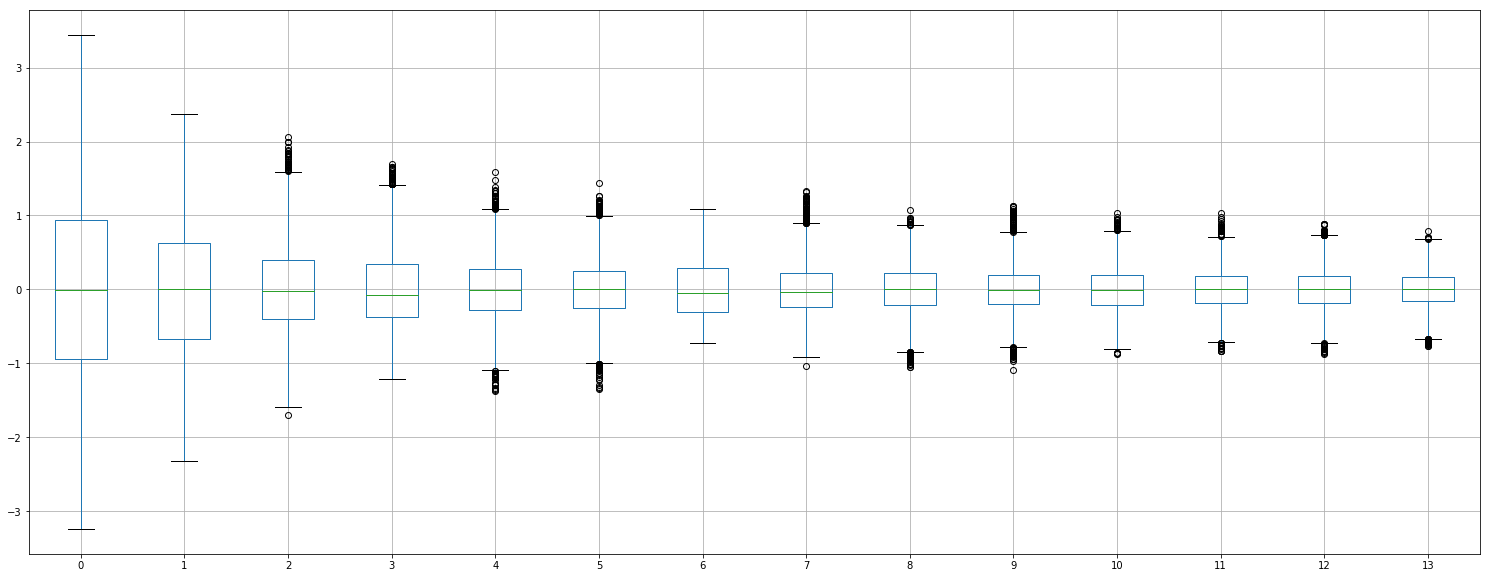

In [158]:
plt.figure(figsize=(26,10))
pca_x_minmax.boxplot()
plt.show()

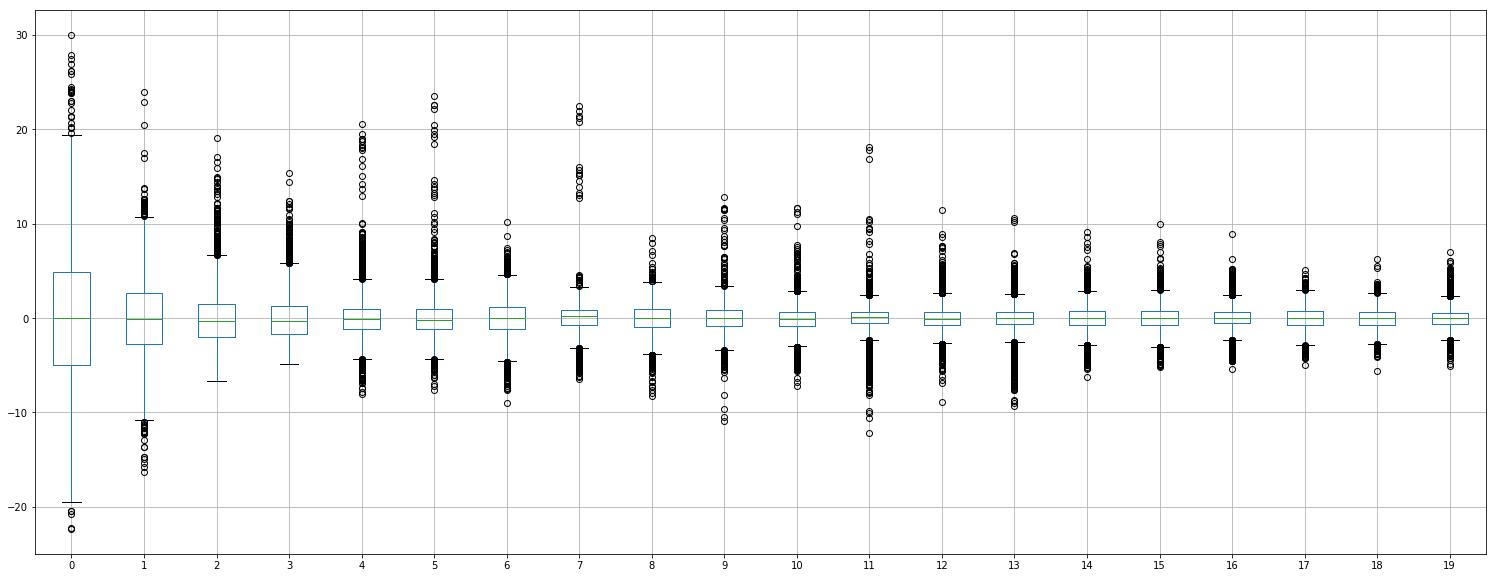

In [159]:
plt.figure(figsize=(26,10))
pca_x_stdscale.boxplot()
plt.show()

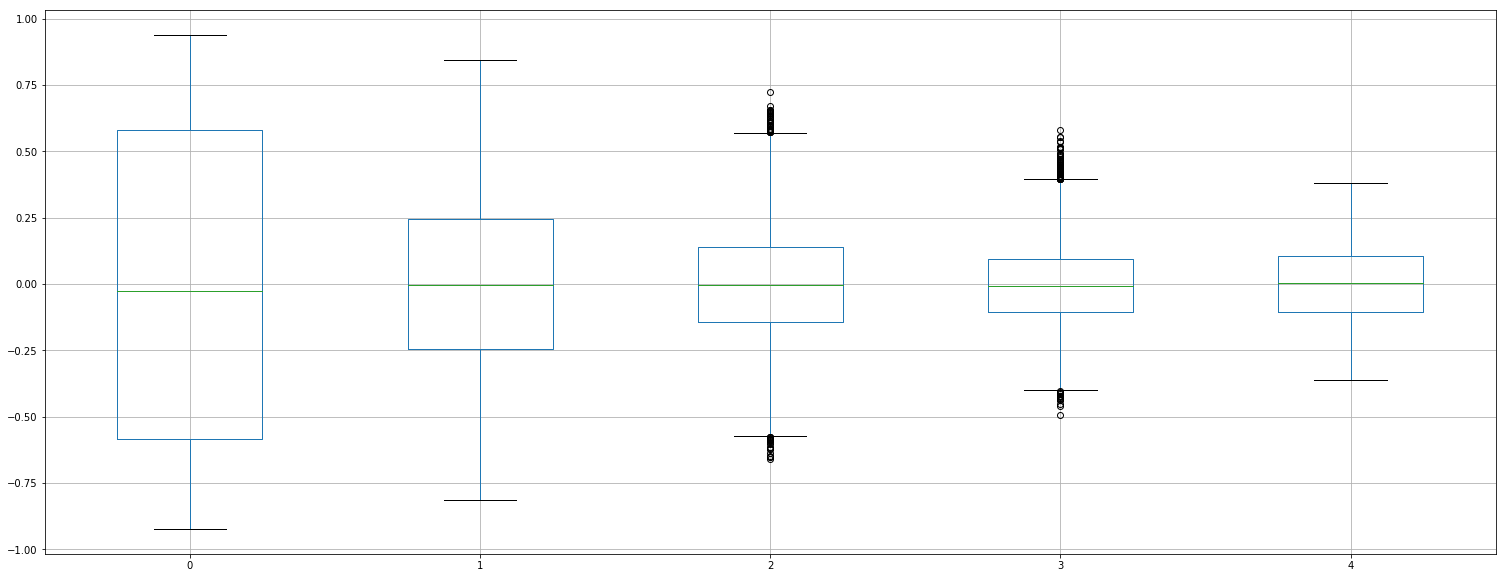

In [160]:
plt.figure(figsize=(26,10))
pca_x_normalizer.boxplot()
plt.show()

### 4.2. Histogram

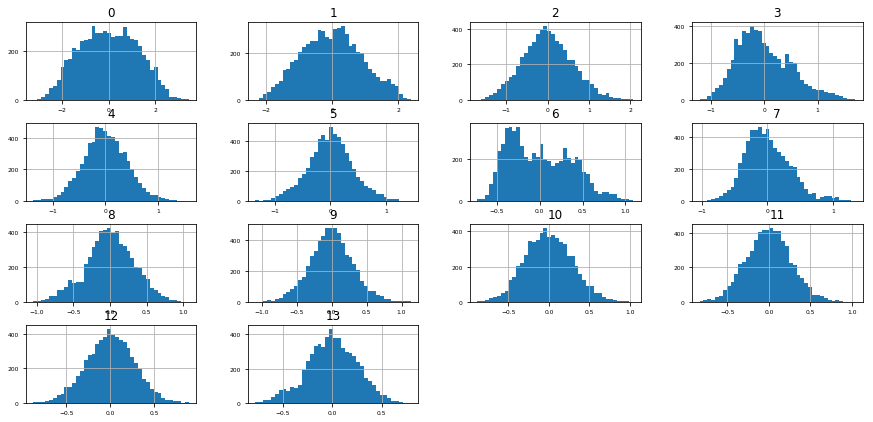

In [161]:
pca_x_minmax.hist(figsize=(15,7), bins=40, xlabelsize=6, ylabelsize=6)
plt.show()

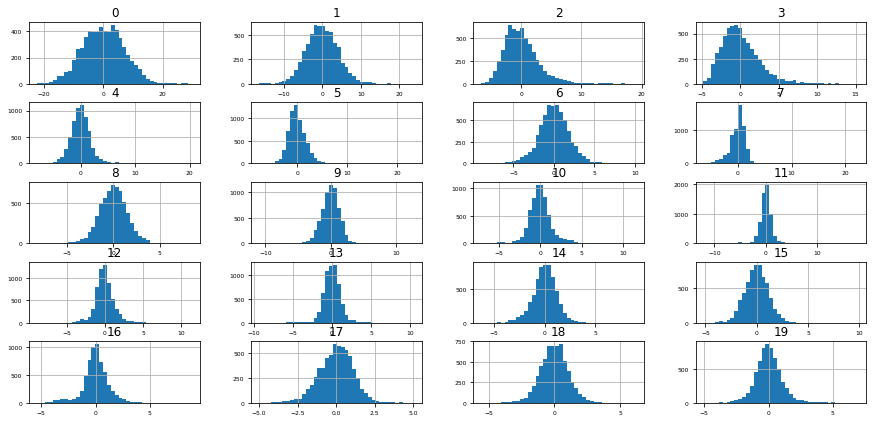

In [162]:
pca_x_stdscale.hist(figsize=(15,7), bins=40, xlabelsize=6, ylabelsize=6)
plt.show()

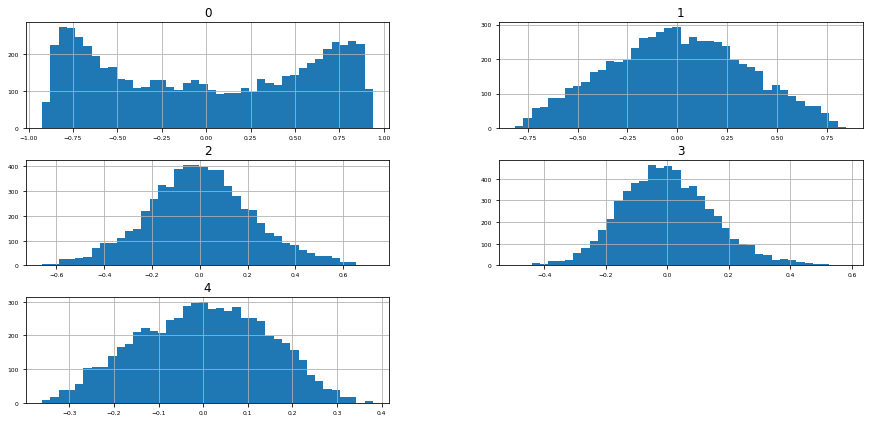

In [163]:
pca_x_normalizer.hist(figsize=(15,7), bins=40, xlabelsize=6, ylabelsize=6)
plt.show()

## 4.3. Shapiro (Normallik) Testi

Normalizasyon isleminden sonra degiskenlerin normallik testine uyup uymadigini test ediyoruz. Regression uygulamak icin normallik varsayimi mevcut

In [164]:
def shapiro_test(dataa):
    stat, p = stats.shapiro(dataa)
    print("Statistics:%3.3f, p=%.3f " % (stat,p))
    alpha = 0.05 
    if p>alpha:
        print("Orneklem Normal (Gaussian) Dagilimdan gelmektedir (Fail to Reject H0)")
    else:
        print("Orneklem Normal (Gaussian) Dagilimdan gelmemektedir (reject H0)")

In [165]:
from scipy.stats import shapiro
shapiro_test(pca_x_normalizer.iloc[:,1:2])

Statistics:0.992, p=0.000 
Orneklem Normal (Gaussian) Dagilimdan gelmemektedir (reject H0)


# 5. Modelling

## 5.1. Train-Test Split

### 5.1.1. Standard Scaler Split

In [166]:
# Standardizasyon Split

xtrain, xtest, ytrain, ytest = train_test_split(pca_x_stdscale, y_20target_minmax, test_size=0.25, random_state=0)
xtrain.shape,  ytrain.shape, xtest.shape, ytest.shape

((4625, 20), (4625,), (1542, 20), (1542,))

### 5.1.2. Normalizer Split

In [167]:
# Normalization Split

xtrain, xtest, ytrain, ytest = train_test_split(pca_x_normalizer, y_20target_minmax, test_size=0.25, random_state=0)
xtrain.shape,  ytrain.shape, xtest.shape, ytest.shape

((4625, 5), (4625,), (1542, 5), (1542,))

### 5.1.3. Min-Max Split

In [168]:
xtrain, xtest, ytrain, ytest = train_test_split(pca_x_minmax, y_20target_minmax, test_size=0.25, random_state=0)
xtrain.shape,  ytrain.shape, xtest.shape, ytest.shape

((4625, 14), (4625,), (1542, 14), (1542,))

## 5.2. Multiple Linear Regression

## - Using Min-Max Normalization

In [169]:
lm = sm.OLS(ytrain, np.asarray(xtrain))
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              20_target   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.527
Date:                Sun, 23 Aug 2020   Prob (F-statistic):            0.00133
Time:                        14:26:41   Log-Likelihood:                -4769.1
No. Observations:                4625   AIC:                             9566.
Df Residuals:                    4611   BIC:                             9656.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0083      0.008     -1.017      0.309      -0.024       0.008
x2            -0.0321      0.011     -2.898      0.004      -0.054      -0.010
x3            -0.0095      0.017     -0.570      0.569      -0.042       0.023
x4             0.0417      0.020      2.097      0.036       0.003       0.081
x5             0.0139      0.025      0.565      0.572      -0.034       0.062
x6            -0.0144      0.025     -0.579      0.562      -0.063       0.034
x7             0.0319      0.027      1.164      0.245      -0.022       0.086
x8            -0.0559      0.029     -1.907      0.057      -0.113       0.002
x9            -0.0836      0.030     -2.772      0.006      -0.143      -0.024
x10            0.0167      0.033      0.509      0.611      -0.048       0.081
x11            0.0519      0.035      1.499      0.134      -0.016       0.120
x12           -0.0280      0.037     -0.751      0.452      -0.101       0.045
x13           -0.0644      0.037     -1.724      0.085      -0.138       0.009
x14           -0.0532      0.040     -1.324      0.186      -0.132       0.026
==============================================================================
Omnibus:                        0.935   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.627   Jarque-Bera (JB):              684.567
Skew:                           0.035   Prob(JB):                    2.23e-149
Kurtosis:                       1.117   Cond. No.                         4.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 5.2.1. Elimination 1

In [170]:
xtrain = xtrain.drop([5], axis=1)
lm = sm.OLS(ytrain, np.asarray(xtrain))
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              20_target   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.696
Date:                Sun, 23 Aug 2020   Prob (F-statistic):           0.000859
Time:                        14:26:41   Log-Likelihood:                -4769.2
No. Observations:                4625   AIC:                             9564.
Df Residuals:                    4612   BIC:                             9648.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0084      0.008     -1.031      0.3

### 5.2.2. Elimination 2

In [171]:
xtrain = xtrain.drop([2], axis=1)
lm = sm.OLS(ytrain, np.asarray(xtrain))
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              20_target   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.894
Date:                Sun, 23 Aug 2020   Prob (F-statistic):           0.000535
Time:                        14:26:41   Log-Likelihood:                -4769.4
No. Observations:                4625   AIC:                             9563.
Df Residuals:                    4613   BIC:                             9640.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0083      0.008     -1.026      0.3

# 6. Evaluation

### 6.1. Hata Karelerinin Hesaplanmasi

In [172]:
y_pred = model.predict(xtrain)
k_t = pd.DataFrame({"gercek_y":ytrain, "tahmin_y":y_pred})
k_t["hata"] = k_t["gercek_y"] - k_t["tahmin_y"]
k_t["hata_kare"] = k_t["hata"]**2
k_t.head()

,gercek_y,tahmin_y,hata,hata_kare
4819,0.030463,-0.016456,0.046919,0.002201
3856,0.012222,-0.020580,0.032802,0.001076
3888,0.013677,-0.057186,0.070863,0.005022
242,0.024296,-0.002378,0.026674,0.000712
1507,0.996548,-0.016477,1.013025,1.026220


In [173]:
np.sum(k_t["hata_kare"])
np.mean(k_t["hata_kare"])

0.4605028874196512

### 6.2. Hata Karelerinin Dagilimi 

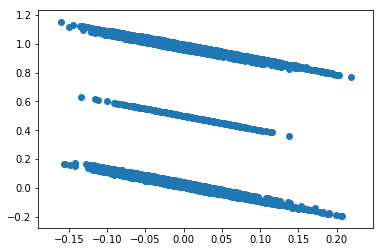

In [174]:
resid = model.resid
plt.scatter(model.predict(), resid)

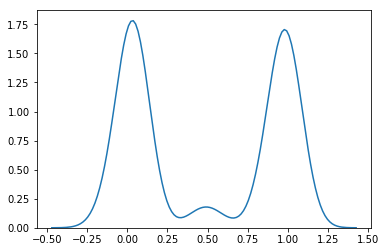

In [175]:
sns.distplot(np.array(model.resid), hist=False)
plt.show()

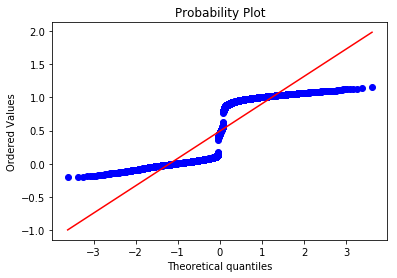

In [176]:
import pylab
stats.probplot(model.resid, dist="norm", plot=pylab)
pylab.show()

In [177]:
from scipy.stats import shapiro

stat, p =shapiro(model.resid)
alpha = 0.05
if p > alpha:
    print('Hatalar Normal (Gaussian) Dağılımdan gelmektedir (Fail to Reject H0)')
else:
    print('Hatalar Normal (Gaussian) Dağılımdan gelmemektedir (reject H0)')

Hatalar Normal (Gaussian) Dağılımdan gelmemektedir (reject H0)


In [182]:
from sklearn.metrics import mean_squared_error, r2_score
print("Train RMSE: ",np.sqrt(mean_squared_error(ytrain, y_pred)))
print("Test  RMSE: ",np.sqrt(mean_squared_error(ytest, model.predict(xtest[xtrain.columns]))))

Train RMSE:  0.6786036305676905
Test  RMSE:  0.6966517125231232


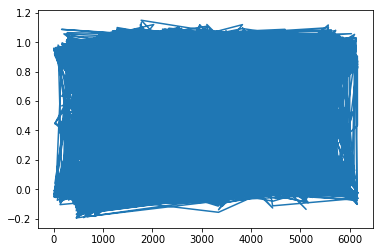

In [183]:
plt.plot(model.resid)
plt.show()